### 데이터셋

In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [2]:
# IOB2 포맷으로 나타낸 시퀀스 예
import pandas as pd
toks = "Jeff Dean is a computer scientist at Google in California".split()
lbls = ["B-PER", "I-PER", "O", "O", "O", "O", "O", "B-ORG", "O", "B-LOC"]
df = pd.DataFrame(data=[toks, lbls], index=['Tokens', 'Tags'])
df

C:\Users\knuyh\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


,0,1,2,3,4,5,6,7,8,9
Tokens,Jeff,Dean,is,a,computer,scientist,at,Google,in,California
Tags,B-PER,I-PER,O,O,O,O,O,B-ORG,O,B-LOC


In [3]:
# XTREME 에서 PAN-X (subset) 중 하나 로드
from datasets import get_dataset_config_names

xtreme_subsets = get_dataset_config_names('xtreme')
print(f"XTREME 서브셋 개수: {len(xtreme_subsets)}")

XTREME 서브셋 개수: 183


In [4]:
panx_subsets = [s for s in xtreme_subsets if s.startswith('PAN')]
panx_subsets[:3]

['PAN-X.af', 'PAN-X.ar', 'PAN-X.bg']

In [5]:
# 독일어 말뭉치 로드
from datasets import load_dataset

load_dataset('xtreme', name = 'PAN-X.de')

DatasetDict({
    train: Dataset({
        features: ['tokens', 'ner_tags', 'langs'],
        num_rows: 20000
    })
    validation: Dataset({
        features: ['tokens', 'ner_tags', 'langs'],
        num_rows: 10000
    })
    test: Dataset({
        features: ['tokens', 'ner_tags', 'langs'],
        num_rows: 10000
    })
})

In [6]:
# 언어 코드를 키로하고, datasetdict 타입의 PAN-X 말뭉치를 값으로 저장
from collections import defaultdict
from datasets import DatasetDict

langs = ['de', 'fr', 'it', 'en'] # 독어, 프랑스어, 이탈리아어, 영어
fracs = [0.629, 0.229, 0.084, 0.059]
# 키가 없는 경우 DatasetDict 반환
panx_ch = defaultdict(DatasetDict)

for lang, frac in zip(langs, fracs) :
    # 다국어 말뭉치 로드
    ds = load_dataset('xtreme', name=f"PAN-X.{lang}")
    # 각 분할을 언어 비율에 따라 다운샘플링
    for split in ds :
        panx_ch[lang][split] = (
            ds[split].shuffle(seed=0).select(range(int(frac * ds[split].num_rows)))) # select : fracs 값을 따라 각 말뭉치 다운샘플링

In [7]:
# 훈련셋에 언어마다 얼마나 많은 샘플이 있는지
pd.DataFrame({lang: [panx_ch[lang]["train"].num_rows] for lang in langs},
             index=["Number of training examples"])

,de,fr,it,en
Number of training examples,12580,4580,1680,1180


In [8]:
# 많은 독어, 제로샷 교차 언어 전이를 외의 언어에 수행
element = panx_ch['de']['train'][0]
for key, value in element.items():
    print(f"{key}:{value}")
# ner_tags : 각 개체명이 매핑된 클래스 ID에 해당 (ner:개체명인식)

tokens:['2.000', 'Einwohnern', 'an', 'der', 'Danziger', 'Bucht', 'in', 'der', 'polnischen', 'Woiwodschaft', 'Pommern', '.']
ner_tags:[0, 0, 0, 0, 5, 6, 0, 0, 5, 5, 6, 0]
langs:['de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de']


In [9]:
for key, value in panx_ch["de"]["train"].features.items():
    print(f"{key}: {value}")

tokens: Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)
ner_tags: Sequence(feature=ClassLabel(names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC'], id=None), length=-1, id=None)
langs: Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)


In [10]:
tags = panx_ch["de"]["train"].features["ner_tags"].feature
print(tags)

ClassLabel(names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC'], id=None)


In [11]:
def create_tag_names(batch) :
    return {'ner_tags_str' : [tags.int2str(idx) for idx in batch['ner_tags']]}

In [12]:
panx_de = panx_ch["de"].map(create_tag_names)

In [13]:
de_example = panx_de['train'][0]
pd.DataFrame([de_example["tokens"], de_example["ner_tags_str"]],
['Tokens', 'Tags'])

,0,1,2,3,4,5,6,7,8,9,10,11
Tokens,2.000,Einwohnern,an,der,Danziger,Bucht,in,der,polnischen,Woiwodschaft,Pommern,.
Tags,O,O,O,O,B-LOC,I-LOC,O,O,B-LOC,B-LOC,I-LOC,O


In [14]:
# 태그가 불균형하게 부여되지 않았나 확인하기 위해 각 분할에서 개체명의 빈도 계산
from collections import Counter

split2freqs = defaultdict(Counter)
for split, dataset in panx_de.items() :
    for row in dataset['ner_tags_str'] :
        for tag in row :
            if tag.startswith('B') :
                tag_type = tag.split('-')[1]
                split2freqs[split][tag_type] += 1
                
pd.DataFrame.from_dict(split2freqs, orient="index")

,LOC,ORG,PER
train,6186,5366,5810
validation,3172,2683,2893
test,3180,2573,3071


### XLM-R 토큰화
XLM-R은 100개 언어의 텍스트에서 훈련된 SentencePiece라는 토크나이저 사용  
(WordPiece 토크나이저 X - BERT)

In [15]:
from transformers import AutoTokenizer

bert_model = 'bert-base-cased'
xlmr_model = 'xlm-roberta-base'
bert_tokenizer = AutoTokenizer.from_pretrained(bert_model)
xlmr_tokenizer = AutoTokenizer.from_pretrained(xlmr_model)

In [16]:
text = 'Jack Sparrow loves New York!'
bert_tokens = bert_tokenizer(text).tokens()
xlmr_tokens = xlmr_tokenizer(text).tokens()

In [17]:
df = pd.DataFrame([bert_tokens, xlmr_tokens], index=["BERT", "XLM-R"])
df

,0,1,2,3,4,5,6,7,8,9
BERT,[CLS],Jack,Spa,##rrow,loves,New,York,!,[SEP],None
XLM-R,<s>,▁Jack,▁Spar,row,▁love,s,▁New,▁York,!,</s>


BERT가 문장 분류 작업에 사용하는 [CLS], [SEP] 토큰 대신,  
XLM-R은 < s >와 < /s >를 사용해 시퀀스의 처음과 끝 표기

* SentencePiece 토크나이저
    * 유니그램이라는 부분단어 분할 방식을 기반으로 각 입력 텍스트를 유니코드 문자 시퀀스로 인코딩
    * 공백 문자가 _문자에 할당되어 언어별 사전 토크나이저에 의존하지 않고 정확하게 시퀀스 복원

In [18]:
"".join(xlmr_tokens).replace(u"\u2581", " ")

'<s> Jack Sparrow loves New York!</s>'

### 트랜스포머 모델 클래스
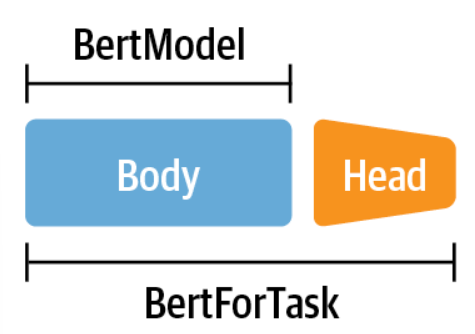

* 토큰 분류를 위한 XLM-R 클래스 생성

In [19]:
import torch.nn as nn
from transformers import XLMRobertaConfig
from transformers.modeling_outputs import TokenClassifierOutput
from transformers.models.roberta.modeling_roberta import RobertaModel
from transformers.models.roberta.modeling_roberta import RobertaPreTrainedModel

class XLMRobertaForTokenClassification(RobertaPreTrainedModel) :
    config_class = XLMRobertaConfig 
    
    def __init__(self, config) :
        super().__init__(config)  # RobertaPreTrainedModel 클래스의 초기화 함수 호출
        self.num_labels = config.num_labels
        # 모델 바디 로드
        self.roberta = RobertaModel(config, add_pooling_layer = False) # [CLS] 토큰에 해당하는 은닉 상태 외 모든 은닉 상태 반환되도록
        # 토큰 분류 헤드 준비
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)
        # 가중치 로드하고 초기화
        self.init_weights()
        
    def forward(self, input_ids = None, attention_mask = None, token_type_ids = None,
               labels = None, **kwargs) :
        # 모델 바디 사용해 인코더 표현 얻음
        outputs = self.roberta(input_ids, attention_mask = attention_mask,
                              token_type_ids = token_type_ids, **kwargs)
        # 인코더 표현을 헤드에 통과
        sequence_output = self.dropout(outputs[0])
        logits = self.classifier(sequence_output)
        # 손실 계산
        loss = None
        if labels is not None :
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
        # 모델 출력 객체 반환
        return TokenClassifierOutput(loss=loss, logits=logits,  # 네임드 튜플로 원소 참조
                                    hidden_states = outputs.hidden_states,
                                    attentions=outputs.attentions)

* 사용자 정의 모델 로드하기

In [20]:
index2tag = {idx: tag for idx, tag in enumerate(tags.names)}
tag2index = {tag: idx for idx, tag in enumerate(tags.names)}

In [21]:
from transformers import AutoConfig

xlmr_config = AutoConfig.from_pretrained(xlmr_model,
                                         num_labels=tags.num_classes,
                                         id2label=index2tag, label2id=tag2index)

In [22]:
xlmr = XLMRobertaForTokenClassification.from_pretrained(xlmr_model, config=xlmr_config) # 기본값 오버라이드

Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [23]:
# 바르게 초기화했는지 확인
input_ids = xlmr_tokenizer.encode(text, return_tensors="pt")
pd.DataFrame([xlmr_tokens, input_ids[0].numpy()], index=["Tokens", "Input IDs"])

,0,1,2,3,4,5,6,7,8,9
Tokens,<s>,▁Jack,▁Spar,row,▁love,s,▁New,▁York,!,</s>
Input IDs,0,21763,37456,15555,5161,7,2356,5753,38,2


In [24]:
import torch
outputs = xlmr(input_ids).logits
predictions = torch.argmax(outputs, dim=-1)
print(f"시퀀스에 있는 토큰 개수: {len(xlmr_tokens)}")
print(f"출력 크기: {outputs.shape}")  # [batch_size, num_tokens, num_tags]
# 각 토큰에는 7개의 NER 태그와 로짓 주어짐

시퀀스에 있는 토큰 개수: 10
출력 크기: torch.Size([1, 10, 7])


In [25]:
preds = [tags.names[p] for p in predictions[0].cpu().numpy()]
pd.DataFrame([xlmr_tokens, preds], index=["Tokens", "Tags"])
# 랜덤한 가중치는 좋지 못한 결과

,0,1,2,3,4,5,6,7,8,9
Tokens,<s>,▁Jack,▁Spar,row,▁love,s,▁New,▁York,!,</s>
Tags,B-PER,B-PER,B-PER,B-PER,I-PER,B-PER,B-PER,B-PER,B-PER,B-PER


In [26]:
def tag_text(text, tags, model, tokenizer):
    tokens = tokenizer(text).tokens()
    input_ids = xlmr_tokenizer(text, return_tensors="pt").input_ids
    outputs = model(input_ids)[0]
    predictions = torch.argmax(outputs, dim=2)
    preds = [tags.names[p] for p in predictions[0].cpu().numpy()]
    return pd.DataFrame([tokens, preds], index=["Tokens", "Tags"])

### NER 작업을 위해 텍스트 토큰화하기

In [27]:
words, labels = de_example['tokens'], de_example['ner_tags']

In [28]:
# 토큰화
tokenized_input = xlmr_tokenizer(de_example['tokens'], is_split_into_words=True) # 입력 문장이 이미 단어로 나눠졌다는 사실 전달
tokens = xlmr_tokenizer.convert_ids_to_tokens(tokenized_input['input_ids'])
pd.DataFrame([tokens], index=['Tokens'])

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
Tokens,<s>,▁2.000,▁Einwohner,n,▁an,▁der,▁Dan,zi,ger,▁Buch,...,▁Wo,i,wod,schaft,▁Po,mmer,n,▁,.,</s>


In [29]:
word_ids = tokenized_input.word_ids() # 각 부분단어를 words 리스트에 있는 해당 단어의 인덱스에 매핑
pd.DataFrame([tokens, word_ids], index=["Tokens", "Word IDs"])
# _2000 : 0, _Einwohner, n : 1 (원래 단어 Einwohnern)
# <s>, </s> : None

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
Tokens,<s>,▁2.000,▁Einwohner,n,▁an,▁der,▁Dan,zi,ger,▁Buch,...,▁Wo,i,wod,schaft,▁Po,mmer,n,▁,.,</s>
Word IDs,None,0,1,1,2,3,4,4,4,5,...,9,9,9,9,10,10,10,11,11,None


In [30]:
previous_word_idx = None
label_ids = []

for word_idx in word_ids :
    if word_idx is None or word_idx == previous_word_idx :
        label_ids.append(-100)
    elif word_idx != previous_word_idx :
        label_ids.append(labels[word_idx])
    previous_word_idx = word_idx

In [31]:
# 특수토큰과 부분단어의 레이블 -100으로 설정 -> 훈련하는동안 마스킹처리
labels = [index2tag[l] if l != -100 else "IGN" for l in label_ids]
index = ["Tokens", "Word IDs", "Label IDs", "Labels"]

pd.DataFrame([tokens, word_ids, label_ids, labels], index=index)

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
Tokens,<s>,▁2.000,▁Einwohner,n,▁an,▁der,▁Dan,zi,ger,▁Buch,...,▁Wo,i,wod,schaft,▁Po,mmer,n,▁,.,</s>
Word IDs,None,0,1,1,2,3,4,4,4,5,...,9,9,9,9,10,10,10,11,11,None
Label IDs,-100,0,0,-100,0,0,5,-100,-100,6,...,5,-100,-100,-100,6,-100,-100,0,-100,-100
Labels,IGN,O,O,IGN,O,O,B-LOC,IGN,IGN,I-LOC,...,B-LOC,IGN,IGN,IGN,I-LOC,IGN,IGN,O,IGN,IGN


In [32]:
def tokenize_and_align_labels(examples):
    tokenized_inputs = xlmr_tokenizer(examples["tokens"], truncation=True,
                                      is_split_into_words=True)
    labels = []
    for idx, label in enumerate(examples["ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=idx)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            if word_idx is None or word_idx == previous_word_idx:
                label_ids.append(-100)
            else:
                label_ids.append(label[word_idx])
            previous_word_idx = word_idx
        labels.append(label_ids)
    tokenized_inputs["labels"] = labels
    return tokenized_inputs

In [33]:
def encode_panx_dataset(corpus):
    return corpus.map(tokenize_and_align_labels, batched=True,
                      remove_columns=['langs', 'ner_tags', 'tokens'])

In [34]:
panx_de_encoded = encode_panx_dataset(panx_ch["de"])

In [35]:
panx_de_encoded['train']

Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 12580
})

### 성능 측정
* 예측 하나를 정확하다고 판단하기 위해 한 개체명에 잇는 모든 단어가 올바르게 예측되어야 한다. -> seqeval 라이브러리

In [36]:
from seqeval.metrics import classification_report

# seqeval : 이중리스트로 구성된 예측과 레이블을 입력받음
y_true = [["O", "O", "O", "B-MISC", "I-MISC", "I-MISC", "O"],
          ["B-PER", "I-PER", "O"]]
y_pred = [["O", "O", "B-MISC", "I-MISC", "I-MISC", "I-MISC", "O"],
          ["B-PER", "I-PER", "O"]]
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

        MISC       0.00      0.00      0.00         1
         PER       1.00      1.00      1.00         1

   micro avg       0.50      0.50      0.50         2
   macro avg       0.50      0.50      0.50         2
weighted avg       0.50      0.50      0.50         2



In [37]:
# 연속된 부분단어의 레이블 ID 무시
import numpy as np

def align_predictions(predictions, label_ids):
    preds = np.argmax(predictions, axis=2)
    batch_size, seq_len = preds.shape
    labels_list, preds_list = [], []

    for batch_idx in range(batch_size):
        example_labels, example_preds = [], []
        for seq_idx in range(seq_len):
            # 레이블 IDs = -100 무시
            if label_ids[batch_idx, seq_idx] != -100:
                example_labels.append(index2tag[label_ids[batch_idx][seq_idx]])
                example_preds.append(index2tag[preds[batch_idx][seq_idx]])

        labels_list.append(example_labels)
        preds_list.append(example_preds)

    return preds_list, labels_list

### XLM-RoBERTa 미세 튜닝하기

In [39]:
from transformers import TrainingArguments

num_epochs = 1 # 2
batch_size = 16
logging_steps = len(panx_de_encoded["train"]) // batch_size
model_name = f"{xlmr_model}-finetuned-panx-de"
training_args = TrainingArguments(
    output_dir="C:/Users/knuyh/Desktop", log_level="error", num_train_epochs=num_epochs,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size, eval_strategy="epoch",
    save_steps=1e6, weight_decay=0.01, disable_tqdm=False,
    logging_steps=logging_steps, push_to_hub=True)

In [40]:
from huggingface_hub import notebook_login
notebook_login()

In [41]:
from seqeval.metrics import f1_score

def compute_metrics(eval_pred):
    y_pred, y_true = align_predictions(eval_pred.predictions,
                                       eval_pred.label_ids)
    return {"f1": f1_score(y_true, y_pred)}

In [42]:
# 배치에서 가장 큰 시퀀스 길이로 입력 시퀀스 패딩
from transformers import DataCollatorForTokenClassification

data_collator = DataCollatorForTokenClassification(xlmr_tokenizer)

텍스트 분류 작업과 달리, 레이블도 시퀀스이기에 레이블 패딩 필수  
레이블 시퀀스를 -100으로 패딩해 손실함수가 무시하도록 만듦

In [43]:
# 매번 새로운 모델 만들지 않도록
def model_init() :
    return XLMRobertaForTokenClassification.from_pretrained(xlmr_model, config=xlmr_config)

In [44]:
from transformers import Trainer

trainer = Trainer(model_init=model_init, args=training_args,
                  data_collator=data_collator, compute_metrics=compute_metrics,
                  train_dataset=panx_de_encoded["train"],
                  eval_dataset=panx_de_encoded["validation"],
                  tokenizer=xlmr_tokenizer)

In [45]:
trainer.train()

Epoch,Training Loss,Validation Loss,F1
1,0.254700,0.169425,0.817135
2,0.118500,0.135656,0.854656


TrainOutput(global_step=1574, training_loss=0.18643604115768794, metrics={'train_runtime': 16615.8901, 'train_samples_per_second': 1.514, 'train_steps_per_second': 0.095, 'total_flos': 528300598518528.0, 'train_loss': 0.18643604115768794, 'epoch': 2.0})

In [46]:
df = pd.DataFrame(trainer.state.log_history)[['epoch','loss' ,'eval_loss', 'eval_f1']]
df = df.rename(columns={"epoch":"Epoch","loss": "Training Loss", "eval_loss": "Validation Loss", "eval_f1":"F1"})
df['Epoch'] = df["Epoch"].apply(lambda x: round(x))
df['Training Loss'] = df["Training Loss"].ffill()
df[['Validation Loss', 'F1']] = df[['Validation Loss', 'F1']].bfill().ffill()
df.drop_duplicates()

,Epoch,Training Loss,Validation Loss,F1
0,1,0.2547,0.169425,0.817135
2,2,0.1185,0.135656,0.854656


In [50]:
text_de = "Jeff Dean ist ein Informatiker bei Google in Kalifornien"
tag_text(text_de, tags, trainer.model, xlmr_tokenizer)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
Tokens,<s>,▁Jeff,▁De,an,▁ist,▁ein,▁Informati,ker,▁bei,▁Google,▁in,▁Kaliforni,en,</s>
Tags,O,B-PER,I-PER,I-PER,O,O,O,O,O,B-ORG,O,B-LOC,I-LOC,O


### 오류분석

In [46]:
# 샘플 시퀀스 토큰마다 손실 계산
from torch.nn.functional import cross_entropy

def forward_pass_with_label(batch) :
    # 리스트의 딕셔너리를 데이터 콜레이터에 적합한 딕셔너리의 리스트로 변환
    features = [dict(zip(batch, t)) for t in zip(*batch.values())]
    # 입력과 레이블을 패딩하고 모든 텐서를 장치에 배치
    batch = data_collator(features)
    input_ids = batch['input_ids']
    attention_mask = batch['attention_mask']
    labels = batch['labels']
    
    with torch.no_grad() :
        # 데이터를 모델에 전달
        output = trainer.model(input_ids, attention_mask)
        # logit size : [batch_size, seq_length, classes]
        # 마지막 축을 따라 가장 큰 로짓 값을 가진 클래스 선택
        predicted_label = torch.argmax(output.logits, axis=-1).cpu().numpy()
    
    # 배치 차원을 펼친 다음 토큰마다 손실 계산
    loss = cross_entropy(output.logits.view(-1, 7),
                        labels.view(-1), reduction='none')
    # 배치 차원 만들고 넘파이 배열로 변환
    loss = loss.view(len(input_ids), -1).cpu().numpy()
    
    return {'loss' : loss, 'predicted_label' : predicted_label}

In [47]:
valid_set = panx_de_encoded["validation"]
valid_set = valid_set.map(forward_pass_with_label, batched=True, batch_size=32)
df = valid_set.to_pandas()

Map:   0%|          | 0/6290 [00:00<?, ? examples/s]

In [48]:
# ID로 인코딩된 토큰과 레이블을 문자열로 변환
index2tag[-100] = "IGN"
df["input_tokens"] = df["input_ids"].apply(
    lambda x: xlmr_tokenizer.convert_ids_to_tokens(x))
df["predicted_label"] = df["predicted_label"].apply(
    lambda x: [index2tag[i] for i in x])
df["labels"] = df["labels"].apply(
    lambda x: [index2tag[i] for i in x])
df['loss'] = df.apply(
    lambda x: x['loss'][:len(x['input_ids'])], axis=1)
df['predicted_label'] = df.apply(
    lambda x: x['predicted_label'][:len(x['input_ids'])], axis=1)
df.head(1)

,input_ids,attention_mask,labels,loss,predicted_label,input_tokens
0,"[0, 10699, 11, 15, 16104, 1388, 2]","[1, 1, 1, 1, 1, 1, 1]","[IGN, B-ORG, IGN, I-ORG, I-ORG, I-ORG, IGN]","[0.0, 2.6628456, 0.0, 2.1013398, 1.999591, 2.0...","[O, O, I-LOC, I-LOC, I-LOC, O, O]","[<s>, ▁Ham, a, ▁(, ▁Unternehmen, ▁), </s>]"


In [49]:
df_tokens = df.apply(pd.Series.explode) # 한 줄 코드로 리스트에 있는 각 원소를 하나의 행으로 만듦
df_tokens = df_tokens.query("labels != 'IGN'") # IGN으로 표시된 패딩 토큰의 손실이 0이므로 제외
df_tokens['loss'] = df_tokens['loss'].astype(float).round(2)
df_tokens.head(7)

,input_ids,attention_mask,labels,loss,predicted_label,input_tokens
0,10699,1,B-ORG,2.66,O,▁Ham
0,15,1,I-ORG,2.10,I-LOC,▁(
0,16104,1,I-ORG,2.00,I-LOC,▁Unternehmen
0,1388,1,I-ORG,2.07,O,▁)
1,56530,1,O,1.61,I-LOC,▁WE
1,83982,1,B-ORG,2.73,I-LOC,▁Luz
1,10,1,I-ORG,2.14,I-LOC,▁a


In [50]:
(
    df_tokens.groupby("input_tokens")[["loss"]]
    .agg(["count", "mean", "sum"])
    .droplevel(level=0, axis=1)  # 멀티 컬럼 삭제
    .sort_values(by="sum", ascending=False)
    .reset_index()
    .round(2)
    .head(10)
    .T
)

,0,1,2,3,4,5,6,7,8,9
input_tokens,▁,▁'',▁',▁der,▁und,▁in,▁die,▁von,▁er,▁den
count,6066,2898,2133,1388,1171,989,860,808,707,489
mean,1.66,1.73,1.68,1.64,1.61,1.66,1.62,1.7,1.69,1.61
sum,10039.24,5005.85,3583.71,2275.44,1887.86,1646.54,1393.56,1372.17,1193.62,785.33


* 공백 토큰의 손실 총합이 가장 크다. -> 리스트에서 가장 많이 등장하는 토큰이기에
* 공백 토큰의 평균 손실은 매우 낮다.-> 모델이 이 토큰을 구분하는 데 큰 힘을 들이지 않음
* in, von, der, und 같은 단어가 비교적 자주 등장 -> 개체명과 함께 등장하거나 개체명의 일부인 경우가 많아 모델이 혼동하기 쉬움
* 단어 시작 부분의 괄호, 슬래시, 대문자는 드물지만 평균 손실이 비교적 높다.

In [51]:
# 레이블 ID 그룹핑하여 각 클래스에 대한 손실
(
    df_tokens.groupby("labels")[["loss"]]
    .agg(["count", "mean", "sum"])
    .droplevel(level=0, axis=1)
    .sort_values(by="mean", ascending=False)
    .reset_index()
    .round(2)
    .T
)

,0,1,2,3,4,5,6
labels,B-ORG,B-LOC,B-PER,I-ORG,I-PER,O,I-LOC
count,2683,3172,2893,3820,4139,43648,1462
mean,2.66,2.27,2.11,2.04,1.76,1.63,1.58
sum,7126.45,7211.46,6101.6,7776.1,7301.57,71356.89,2306.0


* B-ORG 평균 손실이 가장 높다. -> 모델이 조직 이름의 시작 부분을 결정하기 어려움

In [52]:
import matplotlib.pyplot as plt

from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

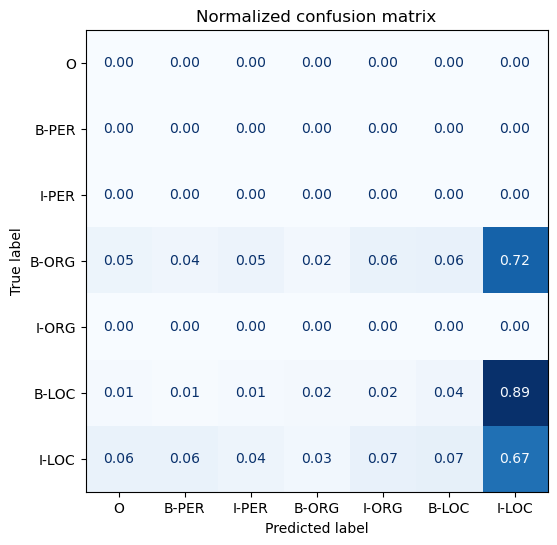

In [53]:
plot_confusion_matrix(df_tokens["labels"], df_tokens["predicted_label"],
                      tags.names)

* B-ORG와 I-ORG를 가장 많이 혼동

In [54]:
# 토큰 시퀀스, 레이블, 손실 출력하는 함수
def get_samples(df):
    for _, row in df.iterrows():
        labels, preds, tokens, losses = [], [], [], []
        for i, mask in enumerate(row["attention_mask"]):
            if i not in {0, len(row["attention_mask"])}:
                labels.append(row["labels"][i])
                preds.append(row["predicted_label"][i])
                tokens.append(row["input_tokens"][i])
                losses.append(f"{row['loss'][i]:.2f}")
        df_tmp = pd.DataFrame({"tokens": tokens, "labels": labels,
                               "preds": preds, "losses": losses}).T
        yield df_tmp

df["total_loss"] = df["loss"].apply(sum)
df_tmp = df.sort_values(by="total_loss", ascending=False).head(3)

for sample in get_samples(df_tmp):
    display(sample)

,0,1,2,3,4,5,6,7,8,9,...,84,85,86,87,88,89,90,91,92,93
tokens,▁Weitere,▁Version,en,▁exist,ieren,▁von,▁Sid,ney,▁Be,chet,...,spo,on,▁und,▁Co,o,tie,▁Williams,▁,.,</s>
labels,O,O,IGN,O,IGN,O,B-PER,IGN,I-PER,IGN,...,IGN,IGN,O,B-PER,IGN,IGN,I-PER,O,IGN,IGN
preds,I-LOC,I-LOC,I-LOC,I-LOC,I-LOC,I-LOC,I-LOC,I-LOC,O,O,...,I-LOC,I-LOC,I-LOC,O,I-LOC,I-LOC,I-LOC,I-LOC,O,O
losses,1.62,1.61,0.00,1.62,0.00,1.70,2.12,0.00,1.80,0.00,...,0.00,0.00,1.62,2.04,0.00,0.00,1.72,1.67,0.00,0.00


,0,1,2,3,4,5,6,7,8,9,...,64,65,66,67,68,69,70,71,72,73
tokens,▁Dabei,▁spielt,e,▁die,▁Gruppe,▁mit,▁Band,s,▁wie,▁Pier,...,▁Ghost,▁Inside,▁und,▁A,▁Day,▁to,▁Remember,▁,.,</s>
labels,O,O,IGN,O,O,O,O,IGN,O,B-ORG,...,I-ORG,I-ORG,O,B-ORG,I-ORG,I-ORG,I-ORG,O,IGN,IGN
preds,O,O,I-LOC,I-LOC,O,I-LOC,O,I-LOC,O,I-LOC,...,O,O,O,I-LOC,I-LOC,O,O,I-LOC,O,O
losses,1.59,1.57,0.00,1.59,1.56,1.68,1.59,0.00,1.59,2.69,...,1.97,1.91,1.60,2.70,2.07,2.13,1.99,1.65,0.00,0.00


,0,1,2,3,4,5,6,7,8,9,...,94,95,96,97,98,99,100,101,102,103
tokens,▁Nachbar,or,te,▁sind,▁D,lou,há,▁L,ho,ta,...,▁Kun,čina,▁Ves,▁im,▁Nord,west,en,▁,.,</s>
labels,O,IGN,IGN,O,B-LOC,IGN,IGN,I-LOC,IGN,IGN,...,B-LOC,IGN,I-LOC,O,O,IGN,IGN,O,IGN,IGN
preds,O,I-LOC,I-LOC,I-LOC,I-LOC,I-LOC,I-LOC,O,I-LOC,I-LOC,...,I-LOC,I-LOC,O,I-LOC,I-LOC,I-LOC,I-LOC,I-LOC,O,O
losses,1.49,0.00,0.00,1.67,2.20,0.00,0.00,1.68,0.00,0.00,...,2.21,0.00,1.56,1.70,1.59,0.00,0.00,1.63,0.00,0.00


In [55]:
df_tmp = df.loc[df["input_tokens"].apply(lambda x: u"\u2581(" in x)].head(2)
for sample in get_samples(df_tmp):
    display(sample)

,0,1,2,3,4,5
tokens,▁Ham,a,▁(,▁Unternehmen,▁),</s>
labels,B-ORG,IGN,I-ORG,I-ORG,I-ORG,IGN
preds,O,I-LOC,I-LOC,I-LOC,O,O
losses,2.66,0.00,2.10,2.00,2.07,0.00


,0,1,2,3,4,5,6,7
tokens,▁Kesk,kül,a,▁(,▁Mart,na,▁),</s>
labels,B-LOC,IGN,IGN,I-LOC,I-LOC,IGN,I-LOC,IGN
preds,O,I-LOC,I-LOC,I-LOC,O,I-LOC,O,O
losses,2.29,0.00,0.00,1.55,1.60,0.00,1.61,0.00


* 괄호와 슬래시의 손실이 비교적 높다.
    * 괄호와 그 안의 내용을 개체명의 일부로 포함시키지 않지만 자동으로 레이블을 부여하는 시스템 때문
    
### 교차 언어 전이
언어 간 성능

In [56]:
def get_f1_score(trainer, dataset):
    return trainer.predict(dataset).metrics["test_f1"]

In [57]:
f1_scores = defaultdict(dict)
f1_scores["de"]["de"] = get_f1_score(trainer, panx_de_encoded["test"])
print(f"[de] 데이터셋에서 [de] 모델의 F1-점수: {f1_scores['de']['de']:.3f}")

[de] 데이터셋에서 [de] 모델의 F1-점수: 0.009


In [58]:
text_fr = "Jeff Dean est informaticien chez Google en Californie"
tag_text(text_fr, tags, trainer.model, xlmr_tokenizer)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
Tokens,<s>,▁Jeff,▁De,an,▁est,▁informatic,ien,▁chez,▁Google,▁en,▁Cali,for,nie,</s>
Tags,O,I-LOC,I-LOC,I-LOC,I-LOC,I-LOC,I-LOC,I-LOC,I-LOC,I-LOC,O,I-LOC,I-LOC,O


In [59]:
# 데이터셋 인코딩하고 분류 리포트 생성
def evaluate_lang_performance(lang, trainer):
    panx_ds = encode_panx_dataset(panx_ch[lang])
    return get_f1_score(trainer, panx_ds["test"])

In [60]:
# 독어에서 미세 튜닝한 모댈을 프랑스어에서 확인
f1_scores["de"]["fr"] = evaluate_lang_performance("fr", trainer)
print(f"[fr] 데이터셋에서 [de] 모델의 F1-점수: {f1_scores['de']['fr']:.3f}")

Map:   0%|          | 0/2290 [00:00<?, ? examples/s]

[fr] 데이터셋에서 [de] 모델의 F1-점수: 0.038


In [78]:
# 이탈리아어에서 성능 평가
f1_scores["de"]["it"] = evaluate_lang_performance("it", trainer)
print(f"[it] 데이터셋에서 [de] 모델의 F1-점수: {f1_scores['de']['it']:.3f}")

[it] 데이터셋에서 [de] 모델의 F1-점수: 0.014


In [62]:
# 영어에서 성능 평가
f1_scores["de"]["en"] = evaluate_lang_performance("en", trainer)
print(f"[en] 데이터셋에서 [de] 모델의 F1-점수: {f1_scores['de']['en']:.3f}")

[en] 데이터셋에서 [de] 모델의 F1-점수: 0.009


#### 제로샷 전이가 유용할 때
* 프랑스어 말뭉치로 훈련셋 크기를 증가시키며 XLM-R을 미세 튜닝해 독일어 XLM-R로 교차 언어 전이한 것보다 나은 결과를 내는 훈련셋 크기 구함

In [74]:
# num_sameples 만큼 샘플링해서 XLM-R 모델을 미세튜닝한 다음, 최상의 에포크에서 얻은 점수 반환
def train_on_subset(dataset, num_samples) :
    train_ds = dataset['train'].shuffle(seed=42).select(range(num_samples))
    valid_ds = dataset['validation']
    test_ds = dataset['test']
    training_args.logging_steps = len(train_ds) // batch_size
    
    trainer = Trainer(model_init = model_init, args = training_args,
                     data_collator=data_collator, compute_metrics=compute_metrics,
                     train_dataset = train_ds, eval_dataset = valid_ds, tokenizer=xlmr_tokenizer)
    trainer.train()
    
    f1_score = get_f1_score(trainer, test_ds)
    return pd.DataFrame.from_dict(
        {"num_samples": [len(train_ds)], "f1_score": [f1_score]})

In [75]:
# 프랑스어 말뭉치 인코딩
panx_fr_encoded = encode_panx_dataset(panx_ch["fr"])

In [ ]:
training_args.push_to_hub = False
metrics_df = train_on_subset(panx_fr_encoded, 250)
metrics_df
# 샘플 250개 사용 : 프랑스어에서 미세 튜닝한 성능 < 독일어에서 제로샷 전이 성능

In [77]:
for num_samples in [500, 1000, 2000, 4000]:
    metrics_df = pd.concat([
        metrics_df,
        train_on_subset(panx_fr_encoded, num_samples)])

NameError: name 'metrics_df' is not defined

NameError: name 'metrics_df' is not defined

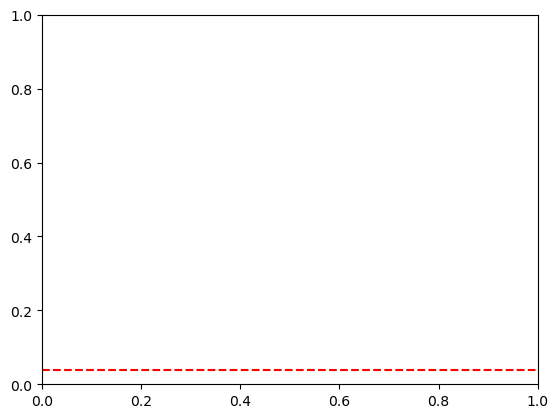

In [81]:
fig, ax = plt.subplots()
ax.axhline(f1_scores["de"]["fr"], ls="--", color="r")
metrics_df.set_index("num_samples").plot(ax=ax)
plt.legend(["Zero-shot from de", "Fine-tuned on fr"], loc="lower right")
plt.ylim((0, 1))
plt.xlabel("Number of Training Samples")
plt.ylabel("F1 Score")
plt.show()

훈련 샘플 약 750개일 때까지 제로샷 전이 앞선다.  
그 후에는 프랑스어 미세 튜닝이 독일어에서 미세 튜닝한 때와 비슷한 수준으로 성능이 향상된다.


#### 다국어에서 동시에 미세 튜닝하기
* 독일어에서 프랑스어/이탈리아어 로 수행된 제로샷 교차 언어 전이에서 성능이 약 15% 떨어졌다.
* 성능 감소 폭을 줄이는 방법 중 하나는 다국어에서 동시에 미세튜닝하는 것

In [82]:
# 프랑스어 + 독일어 말뭉치 합침
from datasets import concatenate_datasets

def concatenate_splits(corpora) :
    multi_corpus = DatasetDict()
    for split in corpora[0].keys() :
        multi_corpus[split] = concatenate_datasets(
        [corpus[split] for corpus in corpora]).shuffle(seed=42)
        
    return multi_corpus

panx_de_fr_encoded = concatenate_splits([panx_de_encoded, panx_fr_encoded])

In [83]:
training_args.logging_steps = len(panx_de_fr_encoded["train"]) // batch_size
#training_args.push_to_hub = True
training_args.output_dir = "xlm-roberta-base-finetuned-panx-de-fr"

trainer = Trainer(model_init=model_init, args=training_args,
    data_collator=data_collator, compute_metrics=compute_metrics,
    tokenizer=xlmr_tokenizer, train_dataset=panx_de_fr_encoded["train"],
    eval_dataset=panx_de_fr_encoded["validation"])

trainer.train()

Epoch,Training Loss,Validation Loss


KeyboardInterrupt: 

In [ ]:
for lang in langs:
    f1 = evaluate_lang_performance(lang, trainer)
    print(f"[{lang}] 데이터셋에서 [de-fr] 모델의 F1-점수: {f1:.3f}")

* 프랑스어 테스트셋 성능이 이전보다 훨씬 좋아져 독일어 테스트셋 성능과 비슷하다.

In [84]:
# 각 언어에서 미세 튜닝한 성능과 전체 말뭉치에서 수행한 다중 언어 학습 비교
corpora = [panx_de_encoded]

# 반복에서 독일어는 제외
for lang in langs[1:]:
    training_args.output_dir = f"xlm-roberta-base-finetuned-panx-{lang}"
    # 단일 언어 말뭉치에서 미세 튜닝
    ds_encoded = encode_panx_dataset(panx_ch[lang])
    metrics = train_on_subset(ds_encoded, ds_encoded["train"].num_rows)
    # 딕셔너리에 F1-점수 모음
    f1_scores[lang][lang] = metrics["f1_score"][0]
    # 단일 언어 말뭉치를 corpora 리스트에 추가
    corpora.append(ds_encoded)

Epoch,Training Loss,Validation Loss


KeyboardInterrupt: 

In [ ]:
# 모든 언어의 분할을 합쳐 네 언어로 구성된 다국어 말뭉치 생성
corpora_encoded = concatenate_splits(corpora)

In [ ]:
training_args.logging_steps = len(corpora_encoded["train"]) // batch_size
training_args.output_dir = "xlm-roberta-base-finetuned-panx-all"

trainer = Trainer(model_init=model_init, args=training_args,
    data_collator=data_collator, compute_metrics=compute_metrics,
    tokenizer=xlmr_tokenizer, train_dataset=corpora_encoded["train"],
    eval_dataset=corpora_encoded["validation"])

trainer.train()

In [ ]:
# 각 언어의 테스트셋에 대한 예측 생성
for idx, lang in enumerate(langs):
    f1_scores["all"][lang] = get_f1_score(trainer, corpora[idx]["test"])
    
scores_data = {"de": f1_scores["de"],
               "each": {lang: f1_scores[lang][lang] for lang in langs},
               "all": f1_scores["all"]}
f1_scores_df = pd.DataFrame(scores_data).T.round(4)
f1_scores_df.rename_axis(index="Fine-tune on", columns="Evaluated on",
                         inplace=True)
f1_scores_df